In [ ]:
pip install chart_studio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.1 MB/s eta 0:00:00


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

In [ ]:
import tensorflow as tf

In [ ]:
df = pd.read_excel('/content/monotonic_pred_force.xlsx')

In [ ]:
df1=df.drop('specimen',axis=1)

In [ ]:
df1

,Force
0,-0.031789
1,473.515200
2,1127.513000
3,1758.178000
4,2352.635000
...,...
143573,343.525000
143574,447.425000
143575,479.375000
143576,607.200000


In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='True')
    plt.plot(predicted, color='blue',label='Predicted')
    plt.title('force Prediction')
    plt.xlabel('time')
    plt.ylabel('force')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
split_fraction = 0.94
train_split = int(split_fraction * int(df.shape[0]))

In [ ]:
train= df1.loc[0 : train_split - 1]
val = df1.loc[train_split:]

In [ ]:
# Checking for missing values
train
#est = df[5140:]

,Force
0,-0.031789
1,473.515200
2,1127.513000
3,1758.178000
4,2352.635000
...,...
134958,41921.050000
134959,41913.025000
134960,41657.400000
134961,41553.550000


In [ ]:
val_data


,Force,specimen
134963,41905.075,B_five
134964,41713.325,B_five
134965,41833.150,B_five
134966,42008.925,B_five
134967,41809.175,B_five
...,...,...
143573,343.525,A_eight
143574,447.425,A_eight
143575,479.375,A_eight
143576,607.200,A_eight


In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
lag_size = len(val)
#print('Max date from train set: %s' % train['date'].max().date())
#print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Forecast lag size 8615


In [ ]:
window = 500
lag = lag_size
series = series_to_supervised(train, window=window, lag=lag)
series.head()

,Force(t-500),Force(t-499),Force(t-498),Force(t-497),Force(t-496),Force(t-495),Force(t-494),Force(t-493),Force(t-492),Force(t-491),...,Force(t-8),Force(t-7),Force(t-6),Force(t-5),Force(t-4),Force(t-3),Force(t-2),Force(t-1),Force(t),Force(t+8615)
500,-0.031789,473.5152,1127.513,1758.178,2352.635,2908.071,3427.315,3927.501,4408.630,4867.268,...,61719.73,59990.18,60813.43,61598.27,60087.39,60907.68,61679.90,59979.90,60770.37,58839.02
501,473.515200,1127.5130,1758.178,2352.635,2908.071,3427.315,3927.501,4408.630,4867.268,5310.202,...,59990.18,60813.43,61598.27,60087.39,60907.68,61679.90,59979.90,60770.37,61555.56,58883.57
502,1127.513000,1758.1780,2352.635,2908.071,3427.315,3927.501,4408.630,4867.268,5310.202,5736.812,...,60813.43,61598.27,60087.39,60907.68,61679.90,59979.90,60770.37,61555.56,60870.30,57674.11
503,1758.178000,2352.6350,2908.071,3427.315,3927.501,4408.630,4867.268,5310.202,5736.812,6150.262,...,61598.27,60087.39,60907.68,61679.90,59979.90,60770.37,61555.56,60870.30,60937.68,56562.84
504,2352.635000,2908.0710,3427.315,3927.501,4408.630,4867.268,5310.202,5736.812,6150.262,6553.412,...,60087.39,60907.68,61679.90,59979.90,60770.37,61555.56,60870.30,60937.68,61732.88,56650.80


In [ ]:
labels

NameError: name 'labels' is not defined

In [ ]:
# Label
labels_col = 'Force(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.1, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (113263, 501)
Validation set shape (12585, 501)


,Force(t-500),Force(t-499),Force(t-498),Force(t-497),Force(t-496),Force(t-495),Force(t-494),Force(t-493),Force(t-492),Force(t-491),...,Force(t-9),Force(t-8),Force(t-7),Force(t-6),Force(t-5),Force(t-4),Force(t-3),Force(t-2),Force(t-1),Force(t)
96040,64330.23,64344.38,64358.59,64372.98,64387.40,64401.64,64415.88,64430.39,64445.10,64459.58,...,66189.66,66202.59,66215.41,66228.23,66241.07,66253.99,66266.98,66279.89,66292.65,66305.26
100636,65041.50,65056.31,65070.96,65085.32,65099.57,65113.82,65127.98,65142.07,65156.24,65170.64,...,65433.64,65444.05,65455.41,65467.53,65480.04,65492.55,65505.07,65517.90,65531.18,65544.70
70698,50633.80,50635.80,50637.80,50639.87,50642.06,50644.27,50646.48,50648.63,50650.63,50652.43,...,51503.83,51505.47,51506.90,51508.22,51509.63,51511.27,51513.02,51514.74,51516.45,51518.19
116681,68142.43,68155.98,68169.42,68183.10,68197.14,68211.16,68224.97,68238.72,68252.55,68266.27,...,68110.29,68123.72,68136.96,68150.36,68164.14,68178.15,68192.13,68205.85,68219.41,68232.97
50835,56703.15,56708.57,56715.71,56724.14,56733.39,56743.21,56753.36,56763.68,56774.23,56785.23,...,58013.04,58021.16,58029.29,58037.28,58045.12,58052.79,58060.28,58067.63,58074.76,58081.82


In [ ]:
Y_train

array([68551.48, 67556.38, 58155.04, ..., 56057.79, 57745.36, 57134.15])

In [ ]:
epochs = 20
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
from keras.optimizers import adam

ImportError: cannot import name 'adam' from 'keras.optimizers' (/usr/local/lib/python3.10/dist-packages/keras/api/optimizers/__init__.py)

In [ ]:
adam1 = optimizers.Adam

In [ ]:
from keras.layers import Dense, Activation, LayerNormalization

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(LayerNormalization(axis=1))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer='adam')
model_mlp.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 100)                 │          50,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 100)                 │             200 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,501 (197.27 KB)

 Trainable params: 50,501 (197.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
3540/3540 - 9s - 3ms/step - loss: 3034137344.0000 - val_loss: 2739178752.0000
Epoch 2/20
3540/3540 - 5s - 1ms/step - loss: 2232828416.0000 - val_loss: 1757764480.0000
Epoch 3/20
3540/3540 - 10s - 3ms/step - loss: 1255190272.0000 - val_loss: 830478208.0000
Epoch 4/20
3540/3540 - 6s - 2ms/step - loss: 535476256.0000 - val_loss: 334416832.0000
Epoch 5/20
3540/3540 - 5s - 1ms/step - loss: 287898656.0000 - val_loss: 254382448.0000
Epoch 6/20
3540/3540 - 6s - 2ms/step - loss: 266946832.0000 - val_loss: 249084976.0000
Epoch 7/20
3540/3540 - 9s - 3ms/step - loss: 266083008.0000 - val_loss: 252308848.0000
Epoch 8/20
3540/3540 - 6s - 2ms/step - loss: 267679184.0000 - val_loss: 251766448.0000
Epoch 9/20
3540/3540 - 11s - 3ms/step - loss: 266614192.0000 - val_loss: 253939840.0000
Epoch 10/20
3540/3540 - 5s - 1ms/step - loss: 271211808.0000 - val_loss: 276954976.0000
Epoch 11/20
3540/3540 - 5s - 1ms/step - loss: 280584448.0000 - val_loss: 266165200.0000
Epoch 12/20
3540/3540 - 6s - 2ms/s

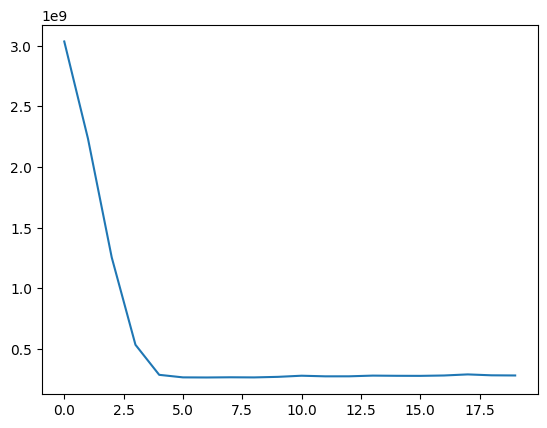

In [ ]:
plt.plot(mlp_history.history['loss'])

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (113687, 30, 1)
Validation set shape (12632, 30, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(LayerNormalization(axis=1))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer="adam")
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 29, 64)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 896)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          44,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 50)                  │             100 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,193 (176.54 KB)

 Trainable params: 45,193 (176.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
3553/3553 - 11s - 3ms/step - loss: 3130009600.0000 - val_loss: 2990182144.0000
Epoch 2/20
3553/3553 - 6s - 2ms/step - loss: 2690024704.0000 - val_loss: 2419300864.0000
Epoch 3/20
3553/3553 - 10s - 3ms/step - loss: 2051071488.0000 - val_loss: 1724161152.0000
Epoch 4/20
3553/3553 - 10s - 3ms/step - loss: 1360651008.0000 - val_loss: 1047366144.0000
Epoch 5/20
3553/3553 - 7s - 2ms/step - loss: 763211968.0000 - val_loss: 536822048.0000
Epoch 6/20
3553/3553 - 9s - 3ms/step - loss: 395883712.0000 - val_loss: 304928832.0000
Epoch 7/20
3553/3553 - 6s - 2ms/step - loss: 292300544.0000 - val_loss: 280150208.0000
Epoch 8/20
3553/3553 - 6s - 2ms/step - loss: 287513472.0000 - val_loss: 279305664.0000
Epoch 9/20
3553/3553 - 7s - 2ms/step - loss: 285584000.0000 - val_loss: 278866304.0000
Epoch 10/20
3553/3553 - 10s - 3ms/step - loss: 283380000.0000 - val_loss: 274628992.0000
Epoch 11/20
3553/3553 - 6s - 2ms/step - loss: 282867584.0000 - val_loss: 273929120.0000
Epoch 12/20
3553/3553 - 10s -

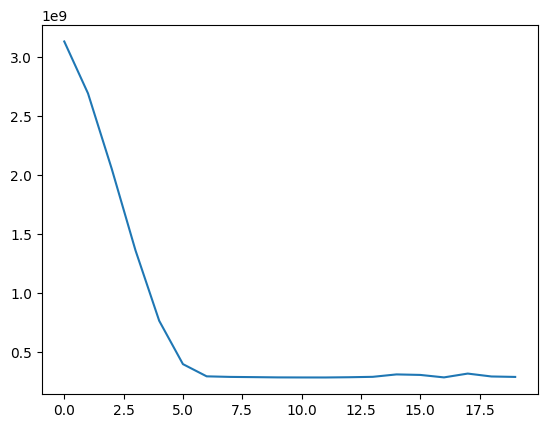

In [ ]:
plt.plot(cnn_history.history['loss'])

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(LayerNormalization(axis=1))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 50)                  │             100 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,551 (41.21 KB)

 Trainable params: 10,551 (41.21 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
3553/3553 - 19s - 5ms/step - loss: 3158102016.0000 - val_loss: 3095479808.0000
Epoch 2/20
3553/3553 - 15s - 4ms/step - loss: 2856206848.0000 - val_loss: 2639792640.0000
Epoch 3/20
3553/3553 - 20s - 6ms/step - loss: 2298491648.0000 - val_loss: 2001137024.0000
Epoch 4/20
3553/3553 - 20s - 6ms/step - loss: 1648943104.0000 - val_loss: 1342851200.0000
Epoch 5/20
3553/3553 - 21s - 6ms/step - loss: 1030390656.0000 - val_loss: 767955648.0000
Epoch 6/20
3553/3553 - 14s - 4ms/step - loss: 556540288.0000 - val_loss: 397285664.0000
Epoch 7/20
3553/3553 - 21s - 6ms/step - loss: 326437280.0000 - val_loss: 284951712.0000
Epoch 8/20
3553/3553 - 14s - 4ms/step - loss: 288986432.0000 - val_loss: 280526752.0000
Epoch 9/20
3553/3553 - 21s - 6ms/step - loss: 289779872.0000 - val_loss: 282861632.0000
Epoch 10/20
3553/3553 - 14s - 4ms/step - loss: 288714752.0000 - val_loss: 280642400.0000
Epoch 11/20
3553/3553 - 20s - 6ms/step - loss: 288608096.0000 - val_loss: 280544768.0000
Epoch 12/20
3553/3553

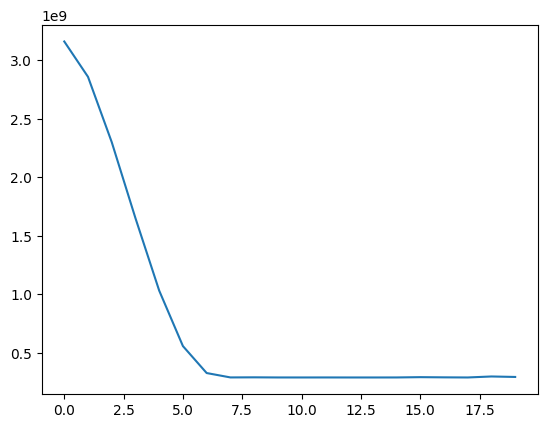

In [ ]:
plt.plot(lstm_history.history['loss'])

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (113687, 2, 15, 1)
Validation set shape (12632, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer='adam')

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
3553/3553 - 13s - 4ms/step - loss: 435061728.0000 - val_loss: 416926944.0000
Epoch 2/20
3553/3553 - 8s - 2ms/step - loss: 434525312.0000 - val_loss: 417501728.0000
Epoch 3/20
3553/3553 - 7s - 2ms/step - loss: 429288928.0000 - val_loss: 418263648.0000
Epoch 4/20
3553/3553 - 8s - 2ms/step - loss: 428402944.0000 - val_loss: 416279104.0000
Epoch 5/20
3553/3553 - 8s - 2ms/step - loss: 428243552.0000 - val_loss: 417081280.0000
Epoch 6/20
3553/3553 - 10s - 3ms/step - loss: 427787552.0000 - val_loss: 422206624.0000
Epoch 7/20
3553/3553 - 10s - 3ms/step - loss: 427195264.0000 - val_loss: 416027104.0000
Epoch 8/20
3553/3553 - 10s - 3ms/step - loss: 426012960.0000 - val_loss: 402458912.0000
Epoch 9/20
3553/3553 - 8s - 2ms/step - loss: 410738816.0000 - val_loss: 397086208.0000
Epoch 10/20
3553/3553 - 10s - 3ms/step - loss: 399429952.0000 - val_loss: 391994528.0000
Epoch 11/20
3553/3553 - 7s - 2ms/step - loss: 398699712.0000 - val_loss: 382220224.0000
Epoch 12/20
3553/3553 - 8s - 2ms/ste

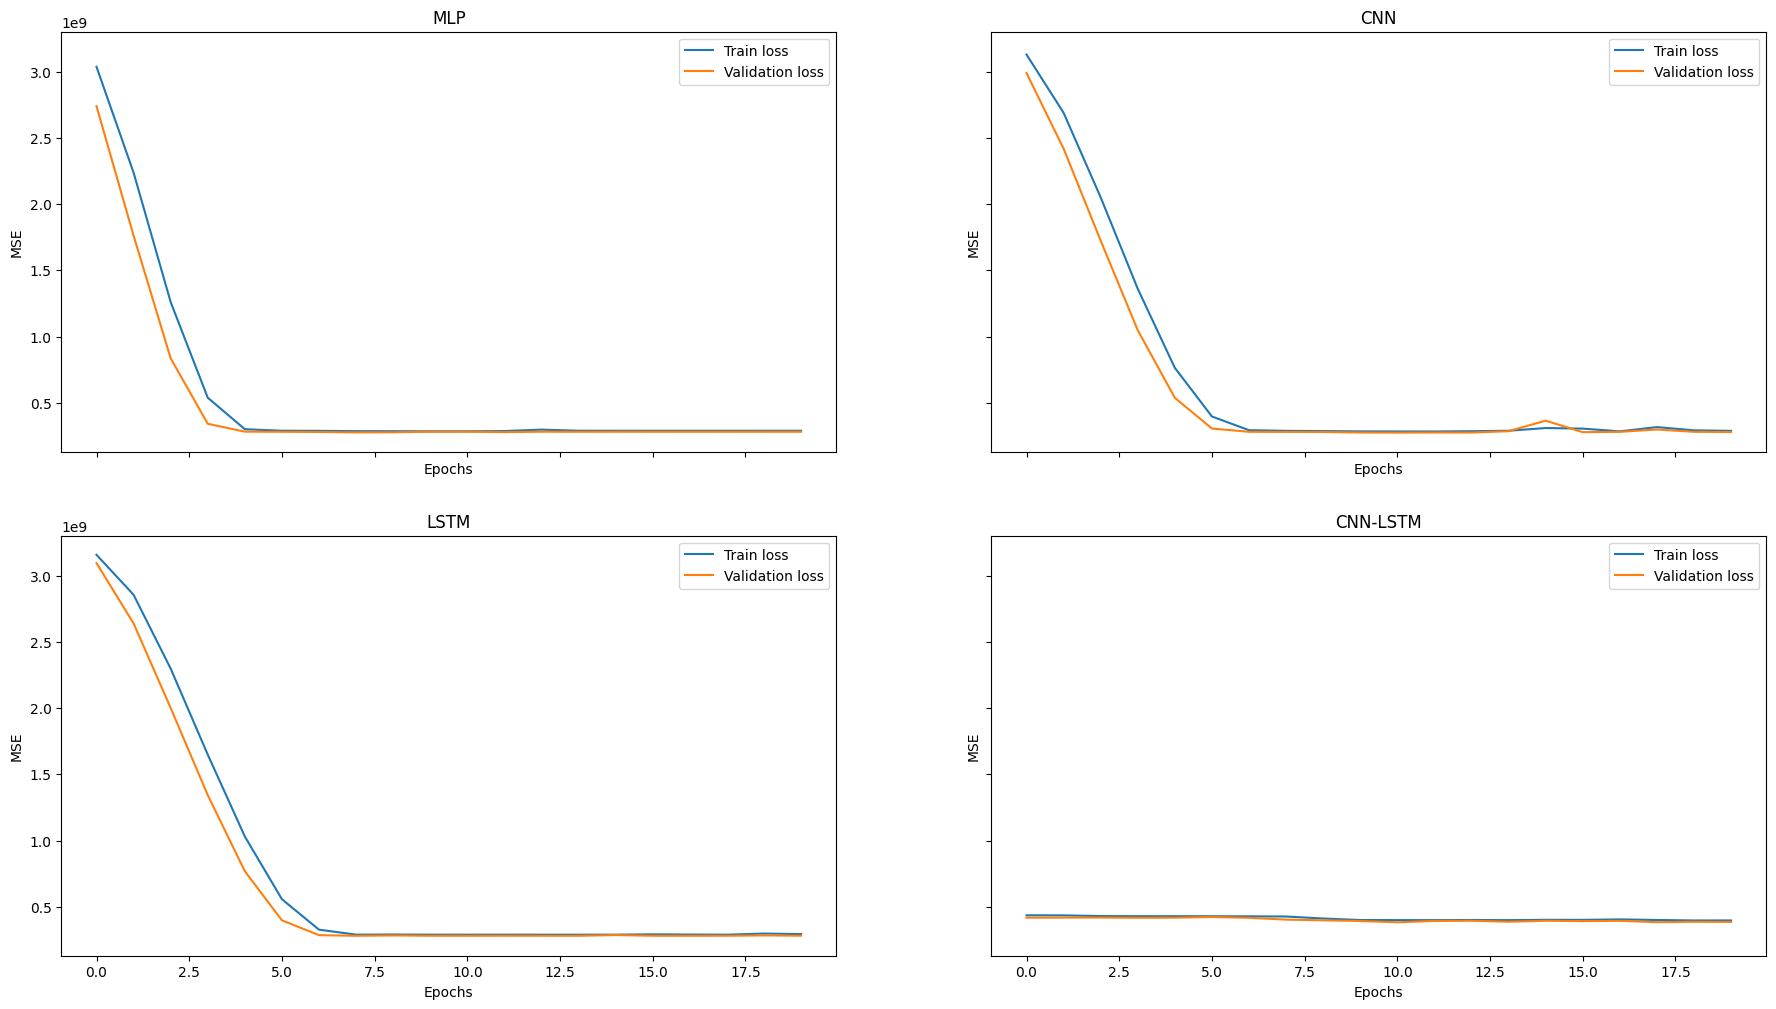

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

3540/3540 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train rmse: 16786.354836172162
Validation rmse: 16395.88547924468


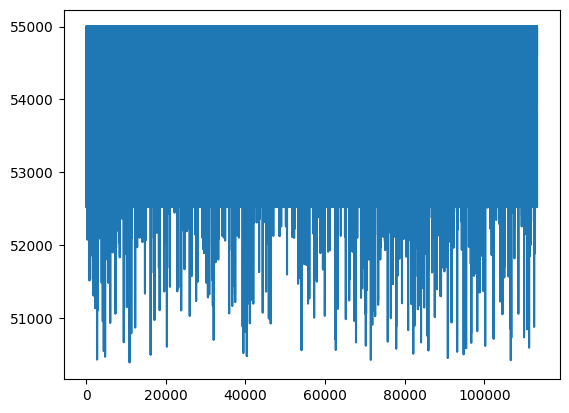

In [ ]:
plt.plot(mlp_train_pred)

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train rmse: 16992.686155035546
Validation rmse: 16684.367927900345


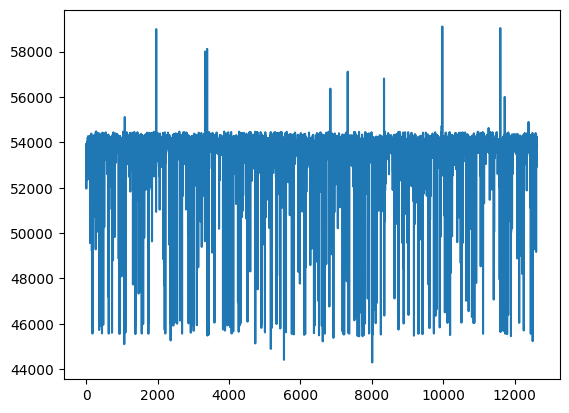

In [ ]:
plt.plot(lstm_valid_pred)

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train rmse: 19831.316667036725
Validation rmse: 19619.064772909936


In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Train rmse: 16904.56686437277
Validation rmse: 16684.367927900345


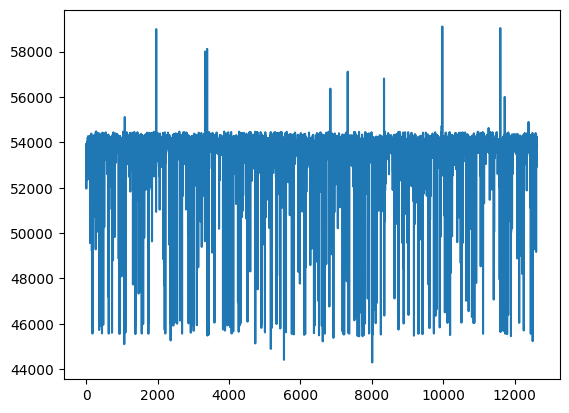

In [ ]:
plt.plot(cnn_valid_pred)